In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas.io.sql as sqlio
import psycopg2

from datetime import datetime
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from kerastuner.tuners import RandomSearch
from tensorflow.keras.metrics import RootMeanSquaredError
from keras import backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from config_user_dta import config

from sklearn.model_selection import GridSearchCV

C:\Users\SUKANY~1\AppData\Local\Temp/ipykernel_8852/1079989437.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Get the config params
params_ = config()

# Connect to the Postgres_DB:
conn = psycopg2.connect(**params_)

sql = "select * from listings;"
data_df = sqlio.read_sql_query(sql, conn)
data_df.head()

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,...,elevator,gym,smoking_allowed,accessible,event_suitable,time_since_first_review,time_since_last_review,avg_rating_overall,avg_rating_overall_cat,borough
0,1419,2008-08-08,unknown,unknown,0.0,1.0,1.0,Little Portugal,43.64590,-79.42423,...,0.0,0.0,0.0,0.0,0.0,4+ years,1+ year,5.000000,excellent,West Toronto
1,27423,2010-05-04,within a few hours,100%,0.0,1.0,1.0,South Riverdale,43.66884,-79.32725,...,0.0,0.0,0.0,0.0,0.0,4+ years,1+ year,4.911429,excellent,East Toronto
2,40456,2010-07-20,within an hour,100%,1.0,3.0,1.0,South Parkdale,43.63539,-79.44010,...,0.0,0.0,0.0,0.0,0.0,4+ years,2-6 months,4.727143,excellent,West Toronto
3,43964,2010-08-05,within an hour,100%,0.0,1.0,1.0,Wexford/Maryvale,43.74922,-79.29188,...,0.0,0.0,0.0,0.0,0.0,4+ years,2-8 weeks,4.948571,excellent,Scarborough
4,573892,2012-04-19,within an hour,100%,0.0,6.0,1.0,Waterfront Communities-The Island,43.64278,-79.37985,...,1.0,1.0,0.0,0.0,0.0,4+ years,2-8 weeks,4.845714,excellent,Downtown Toronto


### Preparing the data for modelling

<AxesSubplot:>

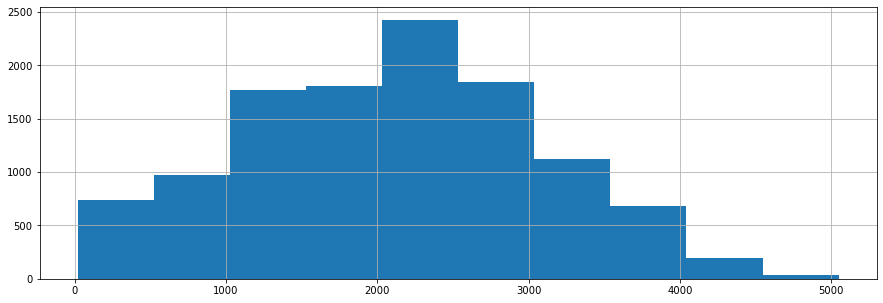

In [3]:
#Checking the host active days column and binning it
data_df.host_active_days.hist(figsize=(15,5))

In [4]:
#Binning
bins=[0, 1094, 1825,2920,3650, 6000]
group_names=["less than 3 years", "3-5 years", "5-8 years","8-10 years","more than 10 years"]
data_df["host_active_days_cat"]= pd.cut(data_df["host_active_days"], bins=bins, labels=group_names, include_lowest=True)

In [5]:
#Total Number of Amenities
col_list=["other_facilities","toiletries", "high_end_electronics","ac_heater","internet",
                "bbq","home_appliances","coffee_machine","long_term_stays","host_greeting","safety","outdoor_space","hot_tub_sauna_or_pool",
              "room_features","private_entrance","parking", "kitchen", "elevator","gym","breakfast","child_friendly",
               "nature_and_views","event_suitable","smoking_allowed","accessible"]
data_df["amenities_sum"]=data_df[col_list].sum(axis=1)

In [6]:
#Create function for multi-collinearity map

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    #Set the style of the visualization
    sns.set(style="white")
    
    #Create a correlation matrix
    corr=df.corr()
    
    #Generate a mask the size of our covariance matrix
    mask=np.zeros_like(corr,dtype=np.bool)
    mask[np.triu_indices_from(mask)]=True
    
    #Set up the matplotlib figure
    f, ax=plt.subplots(figsize=figsize)
    
    #Generate a custom diverging colormap
    cmap=sns.diverging_palette(220,10, as_cmap=True)
    
    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidth=.5, cbar_kws={"shrink":.5}, vmax=corr[corr !=1.0].max().max())

C:\Users\SUKANY~1\AppData\Local\Temp/ipykernel_8852/227191107.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros_like(corr,dtype=np.bool)


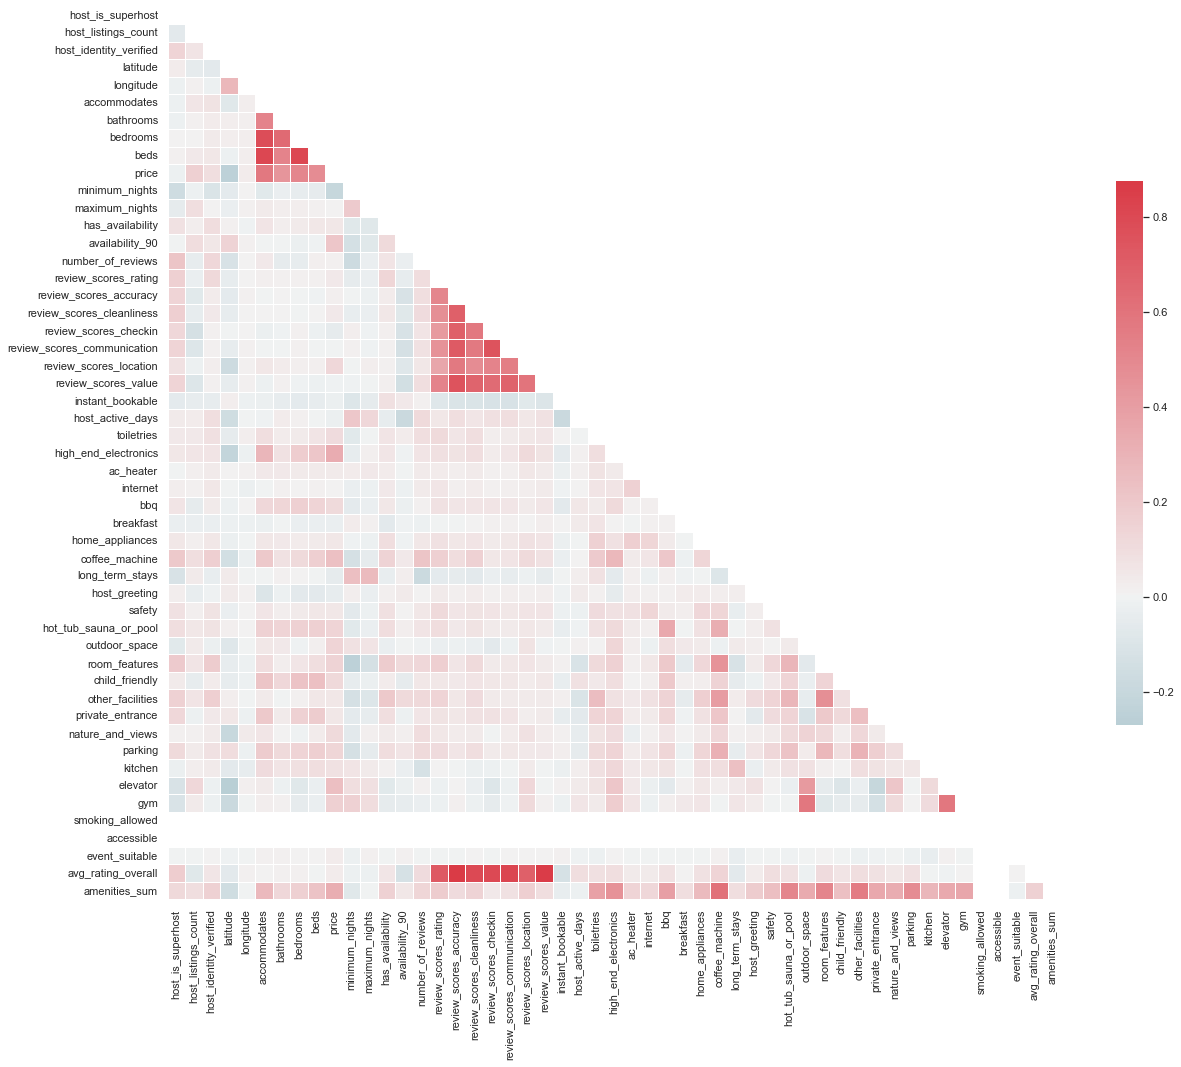

In [7]:
# Check the multi-collinearity for our data
multi_collinearity_heatmap(data_df, figsize=(20,20))

In [8]:
#Drop the columns with high correlation
data_df.drop(columns=["id", "latitude", "longitude","bedrooms","beds","review_scores_rating","review_scores_accuracy","review_scores_communication",
                      "review_scores_location","review_scores_value","room_type","first_review","last_review",
                     "host_since","smoking_allowed","accessible","event_suitable","gym","nature_and_views","review_scores_cleanliness","review_scores_checkin",
                     "other_facilities","toiletries", "high_end_electronics","ac_heater","internet",
                "bbq","home_appliances","coffee_machine","long_term_stays","host_greeting","safety","outdoor_space","hot_tub_sauna_or_pool",
               "room_features","private_entrance","parking", "kitchen", "elevator","gym","breakfast","child_friendly",
             "nature_and_views","event_suitable","time_since_first_review","time_since_last_review"],inplace=True)

In [9]:
data_df["host_active_days_cat"]=data_df["host_active_days_cat"].astype('object')

In [10]:
# Generate our categorical variable lists
data_cat=data_df.dtypes[data_df.dtypes=="object"].index.tolist()
data_cat

['host_response_time',
 'host_response_rate',
 'neighbourhood',
 'property_type',
 'avg_rating_overall_cat',
 'borough',
 'host_active_days_cat']

In [11]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df=pd.DataFrame(enc.fit_transform(data_df[data_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(data_cat)
encode_df.head()

C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,...,borough_North York,borough_Scarborough,borough_West Toronto,borough_York,borough_unkown,host_active_days_cat_3-5 years,host_active_days_cat_5-8 years,host_active_days_cat_8-10 years,host_active_days_cat_less than 3 years,host_active_days_cat_more than 10 years
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
# Merge one-hot encoded features and drop the originals
data_df=data_df.merge(encode_df, left_index=True, right_index=True).drop(data_cat, 1)
data_df.head()

C:\Users\SUKANY~1\AppData\Local\Temp/ipykernel_8852/3153214817.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_df=data_df.merge(encode_df, left_index=True, right_index=True).drop(data_cat, 1)


,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,price,minimum_nights,maximum_nights,has_availability,availability_90,...,borough_North York,borough_Scarborough,borough_West Toronto,borough_York,borough_unkown,host_active_days_cat_3-5 years,host_active_days_cat_5-8 years,host_active_days_cat_8-10 years,host_active_days_cat_less than 3 years,host_active_days_cat_more than 10 years
0,0.0,1.0,1.0,10,3.0,469.0,28,730,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,1,1.0,45.0,90,365,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,3.0,1.0,5,1.0,100.0,28,365,1,53,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,4,1.0,100.0,2,1125,1,22,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,6.0,1.0,2,1.0,119.0,28,1125,1,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# #Create Target and Feature Variables for Machine Learning
X=data_df.drop(["price"], axis=1)
y=data_df["price"]


# #Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=78,train_size=0.8)

In [14]:
# Create a PowerTransformer Instance
scaler=PowerTransformer(method='yeo-johnson')

# # #Fit the StandardScaler
X_scaler=scaler.fit(X_train)

# # #Scale the data
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

In [15]:
def root_mean_squared_error(y_test, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_test,y_pred)))

In [16]:
def create_model(hp):
    model=tf.keras.models.Sequential()
    
    for i in range(hp.Int('num_layers',2,20)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_'+ str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
        hp.Choice('learning_rate',[1e-2, 1e-3, 1e-4])),
        loss=root_mean_squared_error,
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model
       

In [17]:
tuner = kt.Hyperband(
    create_model,
    objective=kt.Objective("root_mean_squared_error", direction="min"),
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [18]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 12s]
root_mean_squared_error: 56.54174041748047

Best root_mean_squared_error So Far: 45.181373596191406
Total elapsed time: 00h 22m 14s
INFO:tensorflow:Oracle triggered exit


In [19]:
#Select the best model
best_model=tuner.get_best_models()[0]
best_model.build(X_train_scaled.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (9274, 416)               79040     
                                                                 
 dense_1 (Dense)             (9274, 384)               160128    
                                                                 
 dense_2 (Dense)             (9274, 160)               61600     
                                                                 
 dense_3 (Dense)             (9274, 288)               46368     
                                                                 
 dense_4 (Dense)             (9274, 288)               83232     
                                                                 
 dense_5 (Dense)             (9274, 512)               147968    
                                                                 
 dense_6 (Dense)             (9274, 448)               2

In [20]:
#Train the model with the best hyperparameters
best_model.fit(X_train_scaled, y_train, epochs=20,batch_size=64)

Epoch 1/20
145/145 [==============================] - 5s 25ms/step - loss: 42.2835 - root_mean_squared_error: 43.6572
Epoch 2/20
145/145 [==============================] - 4s 24ms/step - loss: 40.8417 - root_mean_squared_error: 42.2884
Epoch 3/20
145/145 [==============================] - 3s 23ms/step - loss: 39.6632 - root_mean_squared_error: 41.2066
Epoch 4/20
145/145 [==============================] - 3s 23ms/step - loss: 39.0247 - root_mean_squared_error: 40.5046
Epoch 5/20
145/145 [==============================] - 3s 23ms/step - loss: 37.8820 - root_mean_squared_error: 39.3251
Epoch 6/20
145/145 [==============================] - 3s 23ms/step - loss: 36.9269 - root_mean_squared_error: 38.3366
Epoch 7/20
145/145 [==============================] - 3s 23ms/step - loss: 36.6499 - root_mean_squared_error: 37.6958
Epoch 8/20
145/145 [==============================] - 3s 23ms/step - loss: 36.0877 - root_mean_squared_error: 37.2189
Epoch 9/20
145/145 [==============================] - 3s

In [25]:
#Make predictions with the trained model
root_mean_squared_error(y_test, best_model.predict(X_test_scaled)).numpy()

73/73 [==============================] - 1s 8ms/step


153.1725709120509